<a href="https://colab.research.google.com/github/abiodunarabaa/Loan-Default-Prediction-with-Python/blob/main/Loan%20Default%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from prettytable import PrettyTable




from random import randrange
samp = randrange(100000)


import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("train_v2.csv", error_bad_lines=False)
#data.reset_index(inplace=True)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 771 entries, id to loss
dtypes: float64(680), int64(91)
memory usage: 620.4 MB


In [ ]:
data = data.copy()

mask = data['loss'] != 0

data['default'] = data['loss']

data['default'][mask] = 1

In [ ]:
#check for categorical variables

cat = data.select_dtypes(include='object').columns

cat

#remove columns with categorical variables
data = data.drop(cat,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 772 entries, id to default
dtypes: float64(680), int64(92)
memory usage: 621.2 MB


In [ ]:
from numpy import unique


single = []
for i in range(data.shape[1]):
    if len(unique(data.iloc[:,i])) == 1:
        single.append(data.iloc[:,i].name)



In [ ]:
single

['f33', 'f34', 'f35', 'f37', 'f38', 'f700', 'f701', 'f702', 'f736', 'f764']

In [ ]:
#remove columns with the same value in all rows
data = data.drop(['f33','f34','f35','f37','f38','f700','f701','f702','f736','f764'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 762 entries, id to default
dtypes: float64(680), int64(82)
memory usage: 613.2 MB


In [ ]:
#check for duplicated rows
data.duplicated().any()

False

In [ ]:
#check for duplicated columns
data.T.duplicated().any()

True

In [ ]:
data.isnull()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f771,f772,f773,f774,f775,f776,f777,f778,loss,default
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105466,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
105467,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
105468,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
105469,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#store columns with int values (discrete variables)
#col = data.select_dtypes(include='int64').columns.tolist()

#remove columns duplicated
data = data.T.drop_duplicates().T
data.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 681 entries, id to default
dtypes: float64(681)
memory usage: 548.0 MB


In [ ]:
# Drop rows with missing values
data.dropna(inplace=True)


data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51940 entries, 2 to 105468
Columns: 681 entries, id to default
dtypes: float64(681)
memory usage: 270.3 MB


In [ ]:
# Label encode categorical features if needed
categorical_features = data.select_dtypes(include='float64').columns.tolist()
label_encoder = LabelEncoder()
for feature in categorical_features:
    data[feature] = label_encoder.fit_transform(data[feature])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51940 entries, 2 to 105468
Columns: 681 entries, id to default
dtypes: int64(681)
memory usage: 270.3 MB


In [ ]:
data.isnull().sum()

id         0
f1         0
f2         0
f3         0
f4         0
          ..
f776       0
f777       0
f778       0
loss       0
default    0
Length: 681, dtype: int64

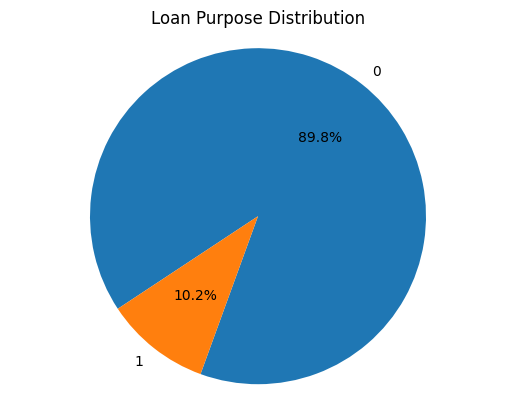

In [ ]:
loan_loss_counts = data['default'].value_counts()
plt.pie(loan_loss_counts, labels=loan_loss_counts.index, autopct='%1.1f%%', startangle=250)
plt.title('Loan Purpose Distribution')
plt.axis('equal')
plt.show()


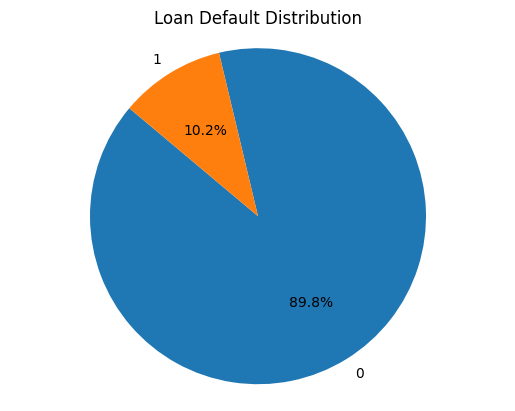

In [ ]:
loan_default_counts = data['default'].value_counts()
plt.pie(loan_default_counts, labels=loan_default_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Loan Default Distribution')
plt.axis('equal')
plt.show()


In [ ]:
import plotly.express as px

loan_purpose_counts = data['default'].value_counts()
fig = px.pie(
    loan_purpose_counts,
    labels=loan_purpose_counts.index,
    values=loan_purpose_counts.values,
    title='Loan default Distribution',
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.update_traces(textinfo='percent+label', pull=[0.2, 0, 0, 0])  # Adjust pull and text position
fig.update_layout(showlegend=True)
fig.show()


In [ ]:
default_counts = data['default'].value_counts()
fig = px.pie(
    default_counts,
    values=default_counts.values,
    labels=default_counts.index,
    title='Loan default Distribution',
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.update_traces(textinfo='percent+label', pull=[0.3 , 0, 0, 0])  # Adjusting pull and text position
fig.update_layout(showlegend=True)
fig.show()


In [ ]:
# Split the data into training and testing sets
features = data.drop([ 'default', 'loss'], axis=1)
target = data['default']

# Apply Min-Max scaling to features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)



X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
# np.any(np.isnan(features))

Training NaiveBayes
Training LogisticRegression
Training DecisionTreeClassifier
Training KNN
Training RandomForestClassifier
+------------------------+--------------------+--------------------+----------------------+-----------------------+-----------------------+----------------------+--------------------+--------------------+
|       Classifier       |  Accuracy (Train)  |  Accuracy (Test)   |   F1-Score (Train)   |    F1-Score (Test)    |    F2-Score (Train)   |   F2-Score (Test)    |  ROC-AUC (Train)   |   ROC-AUC (Test)   |
+------------------------+--------------------+--------------------+----------------------+-----------------------+-----------------------+----------------------+--------------------+--------------------+
|       NaiveBayes       | 0.5974201001155179 | 0.6030997304582211 | 0.22303762192289825  |  0.22251555723175562  |  0.35051094890510953  |  0.3508563273073263  | 0.6138229373573982 | 0.6168184947762763 |
|   LogisticRegression   | 0.8976703889102811 | 0.89988

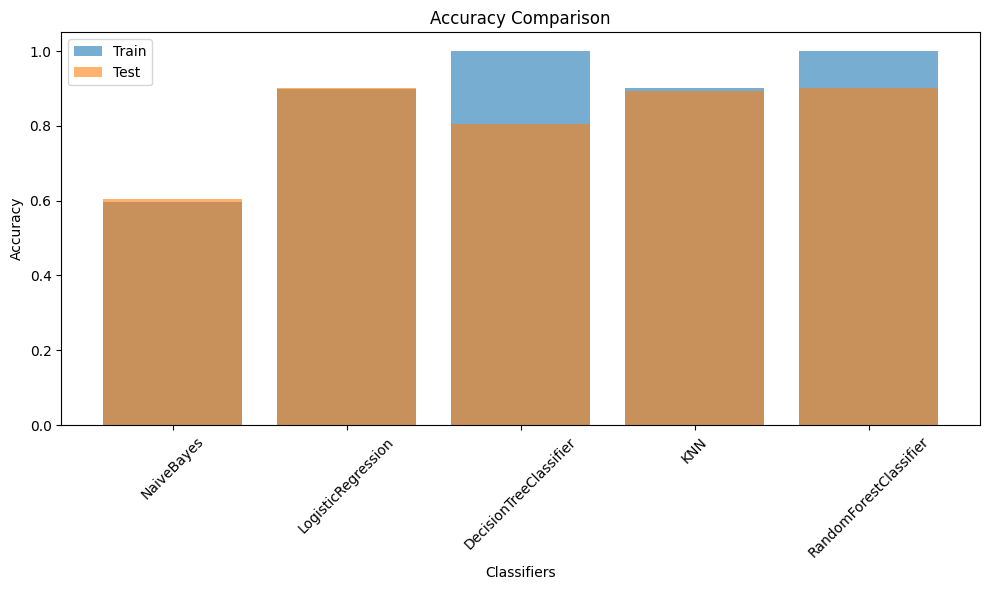

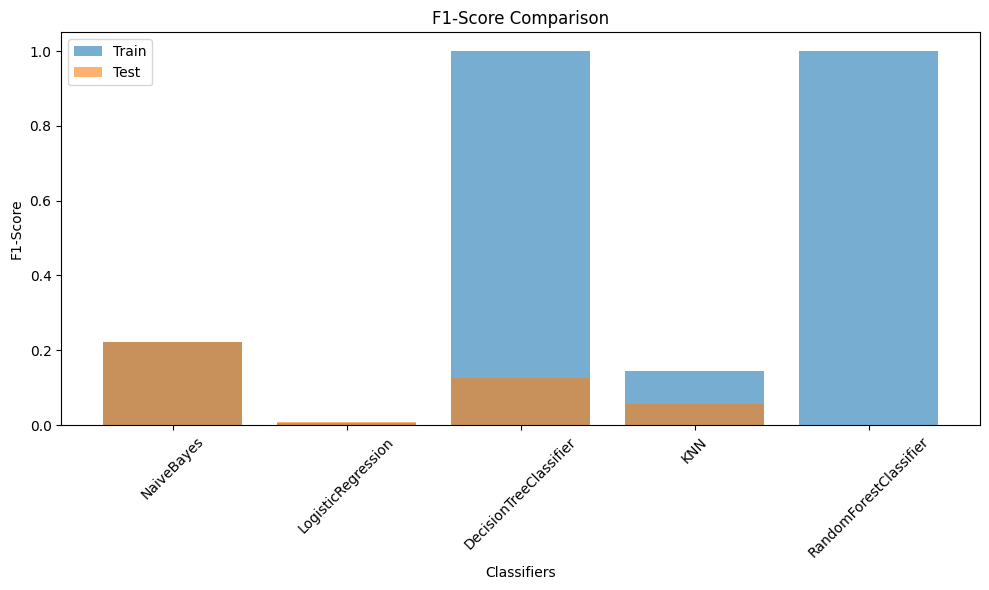

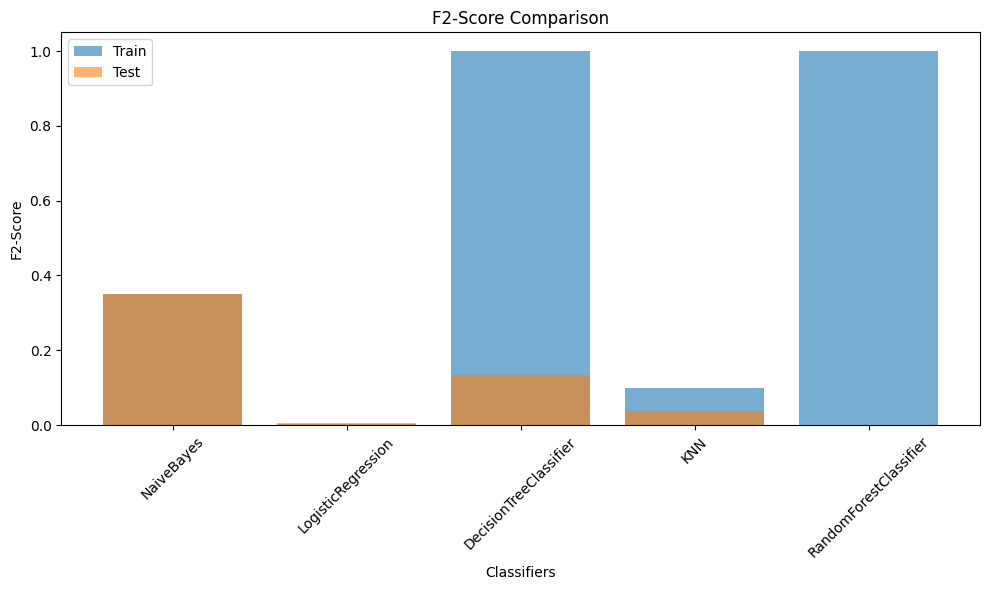

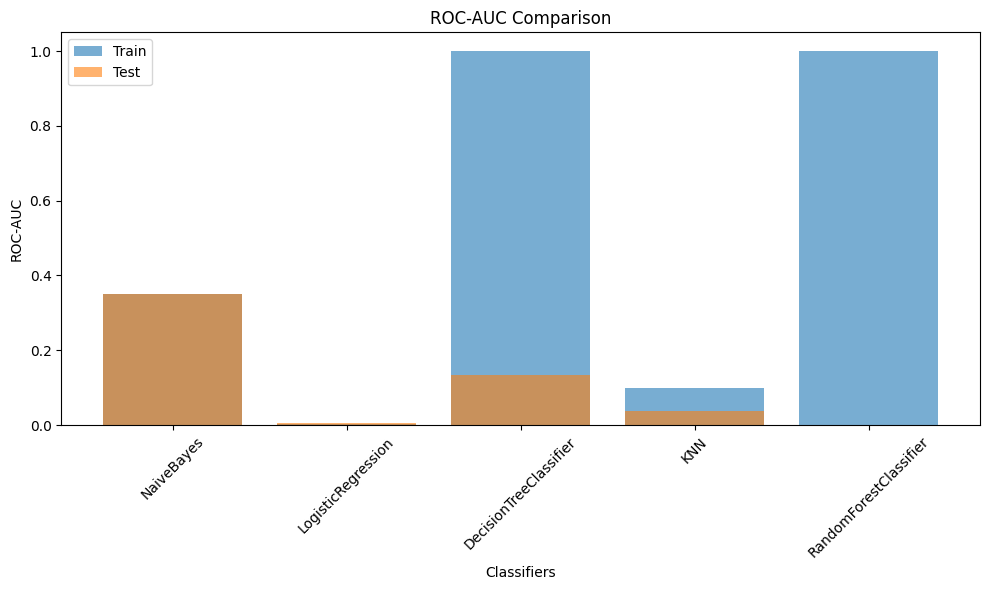

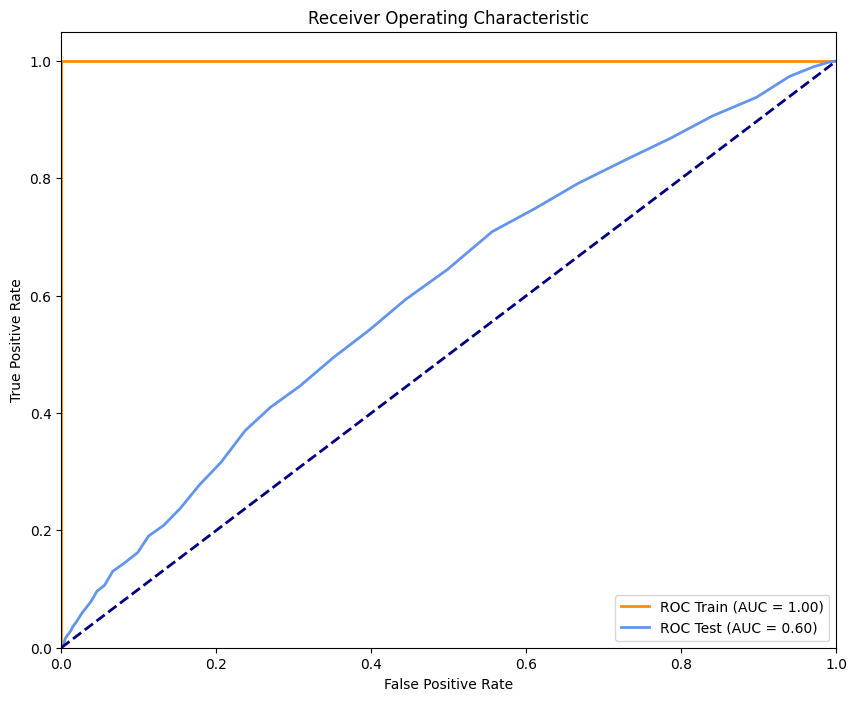

In [ ]:
# Define classifiers
classifiers = {
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

# Initialize the table
result_table = PrettyTable()
result_table.field_names = ['Classifier', 'Accuracy (Train)', 'Accuracy (Test)',
                            'F1-Score (Train)', 'F1-Score (Test)', 'F2-Score (Train)', 'F2-Score (Test)', 'ROC-AUC (Train)', 'ROC-AUC (Test)']

# Initialize lists for visualization
metrics = ['Accuracy', 'F1-Score', 'F2-Score', 'ROC-AUC']
train_scores = {metric: [] for metric in metrics}
test_scores = {metric: [] for metric in metrics}

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}")

    # Perform GridSearchCV for parameter selection
    clf_cv = GridSearchCV(clf, param_grid={}, cv=5, error_score='raise')
    clf_cv.fit(X_train, y_train)

    # Calculate metrics for validation
    clf_train_pred = clf_cv.predict(X_train)
    clf_test_pred = clf_cv.predict(X_test)

    accuracy_train = accuracy_score(y_train, clf_train_pred)
    accuracy_test = accuracy_score(y_test, clf_test_pred)

    #mse_train = mean_squared_error(y_train, clf_train_pred)
    #mse_test = mean_squared_error(y_test, clf_test_pred)

    f1_train = f1_score(y_train, clf_train_pred)
    f1_test = f1_score(y_test, clf_test_pred)

    f2_train = fbeta_score(y_train, clf_train_pred, beta=2)
    f2_test = fbeta_score(y_test, clf_test_pred, beta=2)

    clf_train_prob = clf_cv.predict_proba(X_train)[:, 1]
    clf_test_prob = clf_cv.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, clf_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, clf_test_prob)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Print and add to table
    result_table.add_row([clf_name, accuracy_train, accuracy_test, f1_train, f1_test, f2_train, f2_test, roc_auc_train, roc_auc_test])


    # Store scores for visualization
    train_scores['Accuracy'].append(accuracy_train)
    test_scores['Accuracy'].append(accuracy_test)

    #train_scores['MSE'].append(mse_train)
    #test_scores['MSE'].append(mse_test)

    train_scores['F1-Score'].append(f1_train)
    test_scores['F1-Score'].append(f1_test)

    train_scores['F2-Score'].append(f2_train)
    test_scores['F2-Score'].append(f2_test)

    train_scores['ROC-AUC'].append(f2_train)
    test_scores['ROC-AUC'].append(f2_test)


# Display the result table
print(result_table)

# Generate visuals
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(classifiers.keys(), train_scores[metric], label='Train', alpha=0.6)
    plt.bar(classifiers.keys(), test_scores[metric], label='Test', alpha=0.6)
    plt.xlabel('Classifiers')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Train (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'ROC Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Methodology 1: The ROC')
plt.legend(loc="lower right")
plt.show()




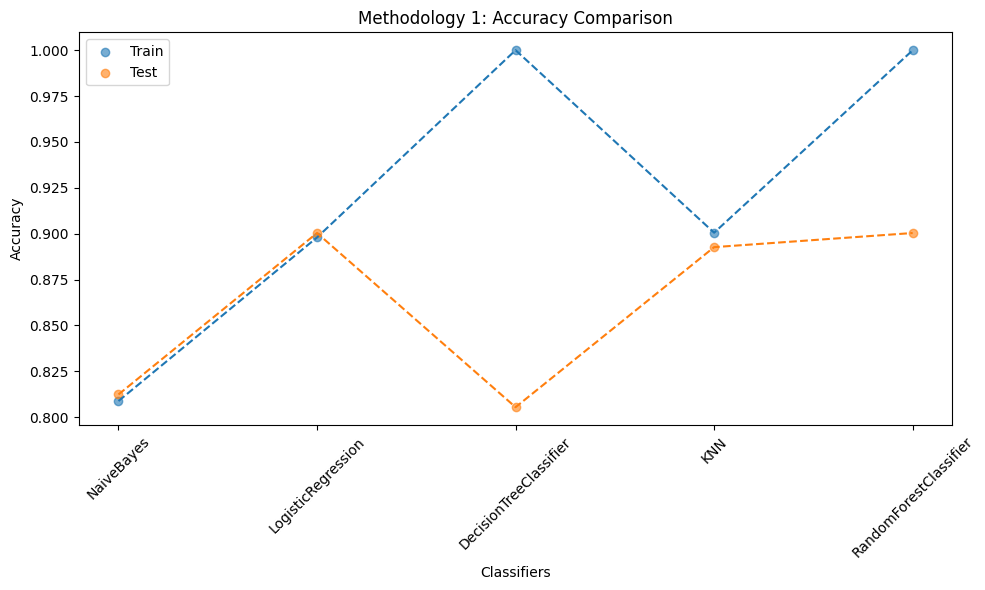

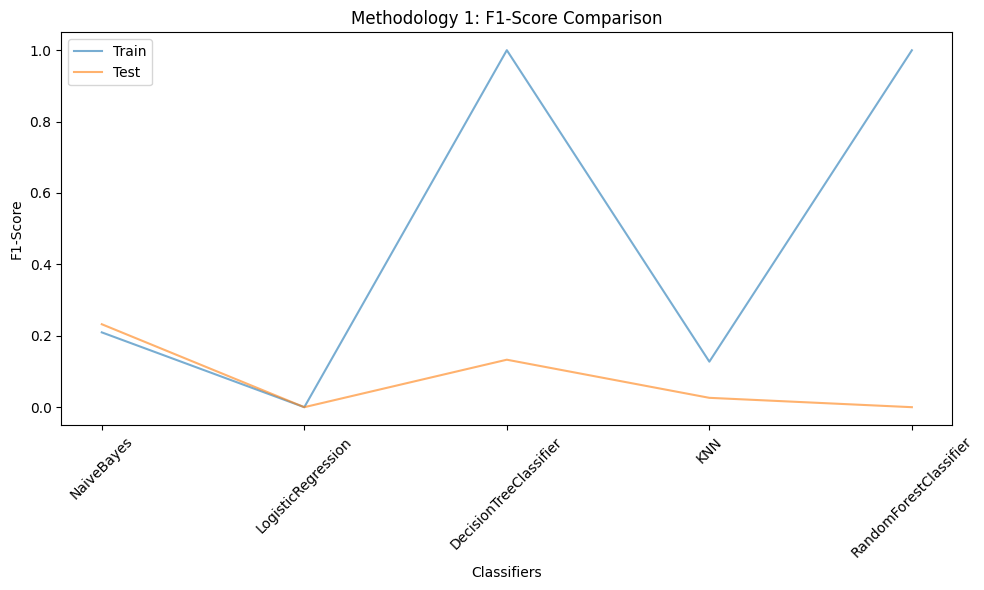

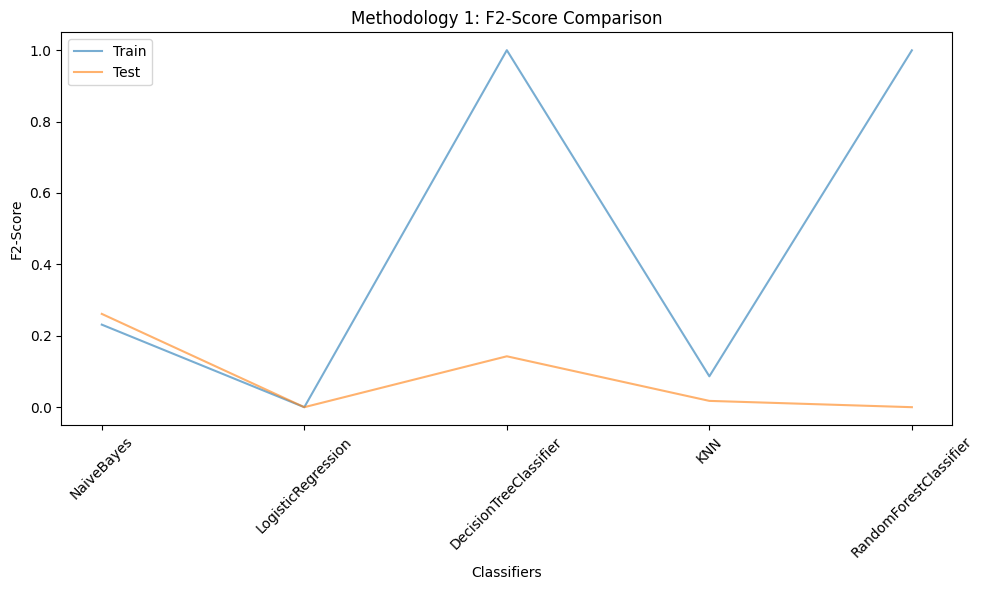

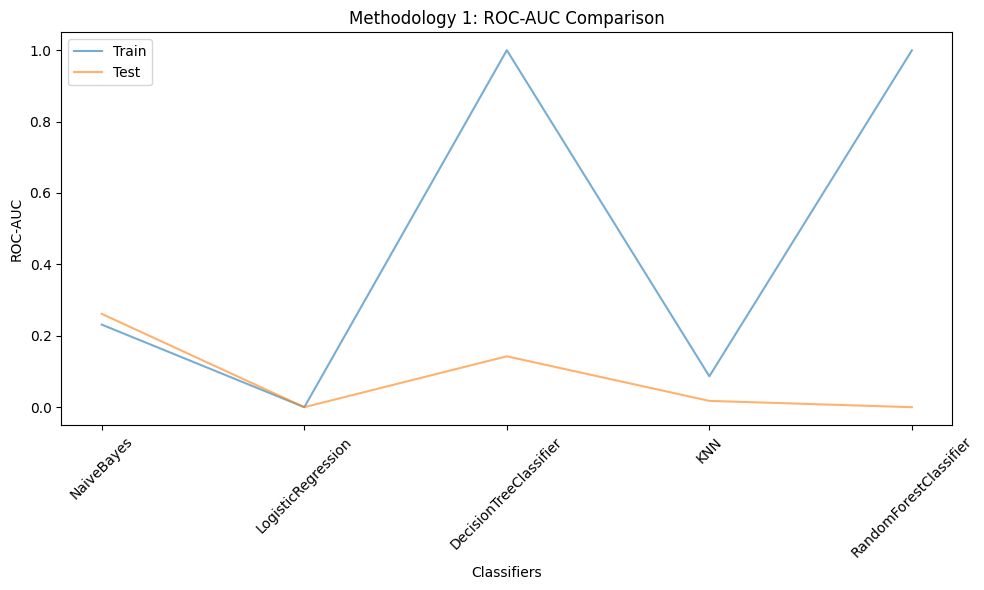

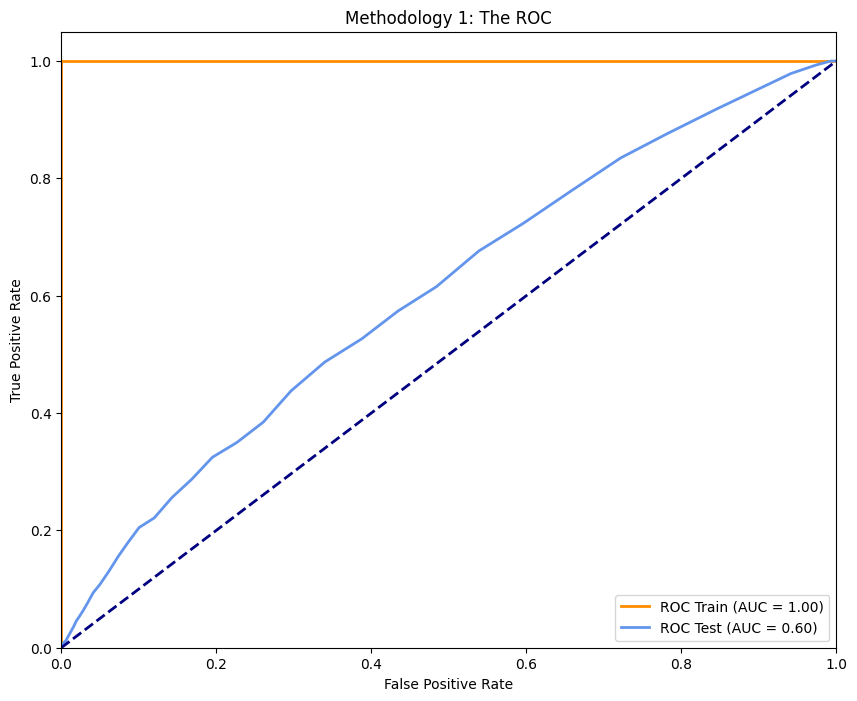

In [ ]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    if metric == 'Accuracy':
        plt.scatter(classifiers.keys(), train_scores[metric], label='Train', alpha=0.6)
        plt.scatter(classifiers.keys(), test_scores[metric], label='Test', alpha=0.6)
        plt.plot(classifiers.keys(), train_scores[metric], linestyle='--')
        plt.plot(classifiers.keys(), test_scores[metric], linestyle='--')
    else:
        plt.plot(classifiers.keys(), train_scores[metric], label='Train', alpha=0.6)
        plt.plot(classifiers.keys(), test_scores[metric], label='Test', alpha=0.6)
    plt.xlabel('Classifiers')
    plt.ylabel(metric)
    plt.title(f'Methodology 1: {metric} Comparison')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Train (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'ROC Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Methodology 1: The ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel

Training the NaiveBayes
Training the LogisticRegression
Training the DecisionTreeClassifier
Training the KNN
Training the RandomForestClassifier
+------------------------+--------------------+--------------------+---------------------+----------------------+---------------------+----------------------+--------------------+--------------------+
|         Models         |  Accuracy (Train)  |  Accuracy (Test)   |   F1-Score (Train)  |   F1-Score (Test)    |   F2-Score (Train)  |   F2-Score (Test)    |  ROC-AUC (Train)   |   ROC-AUC (Test)   |
+------------------------+--------------------+--------------------+---------------------+----------------------+---------------------+----------------------+--------------------+--------------------+
|       NaiveBayes       | 0.8088178667693493 | 0.8123796688486715 | 0.20955223880597013 | 0.23237495076801887  | 0.23122529644268772 | 0.26133947554925585  | 0.6364079402347163 | 0.6547987134769334 |
|   LogisticRegression   | 0.8979591836734694 | 0.9

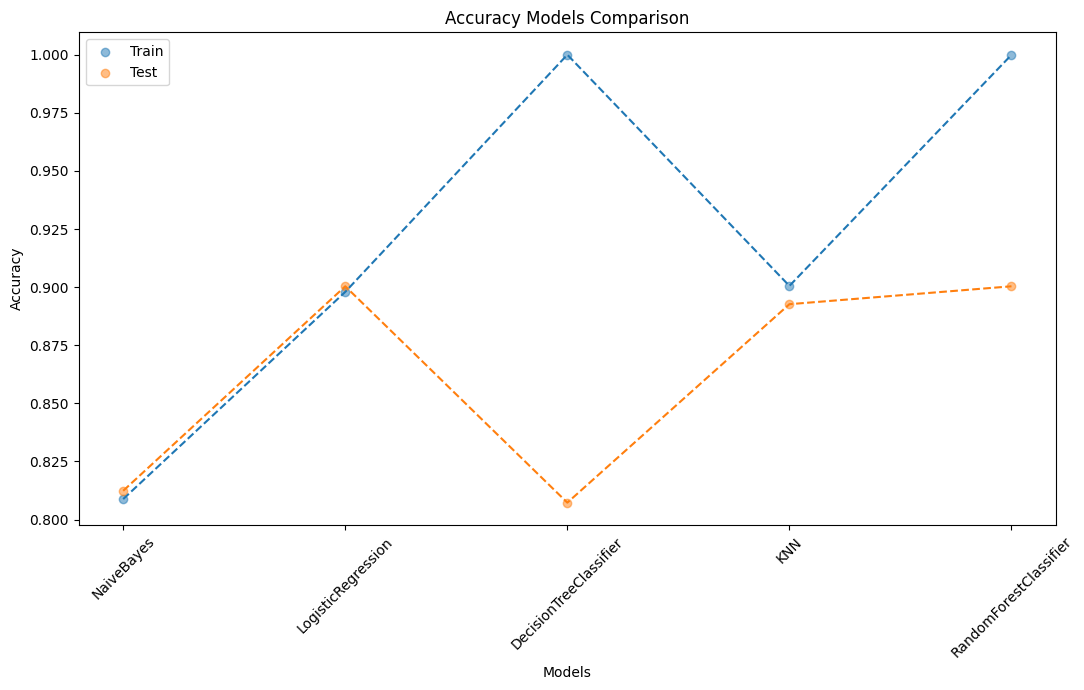

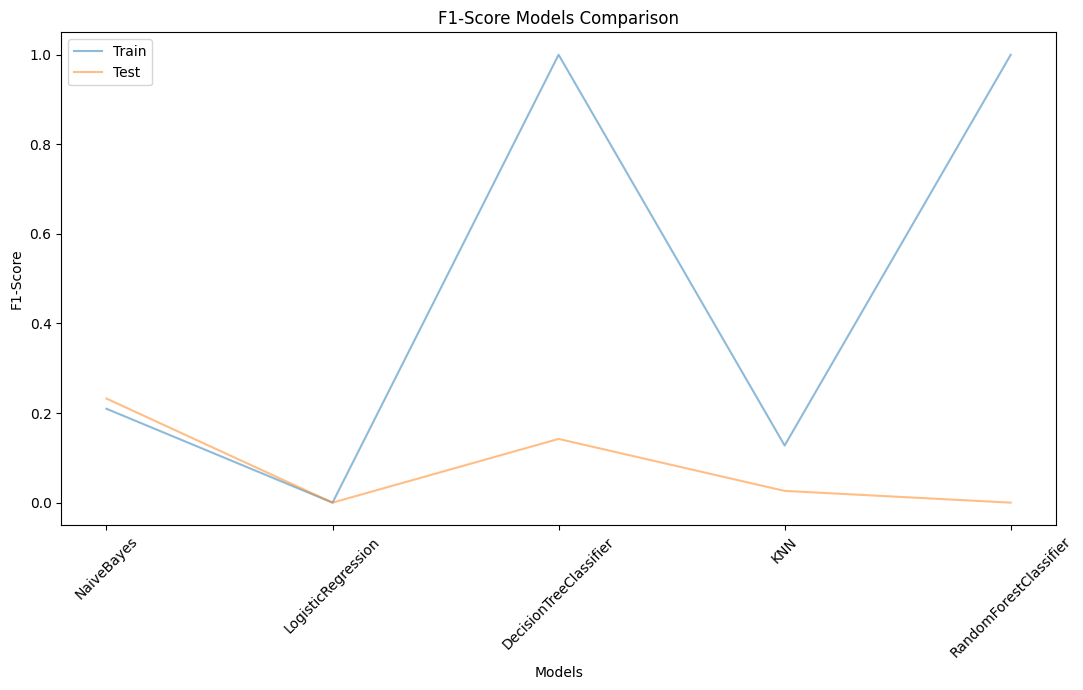

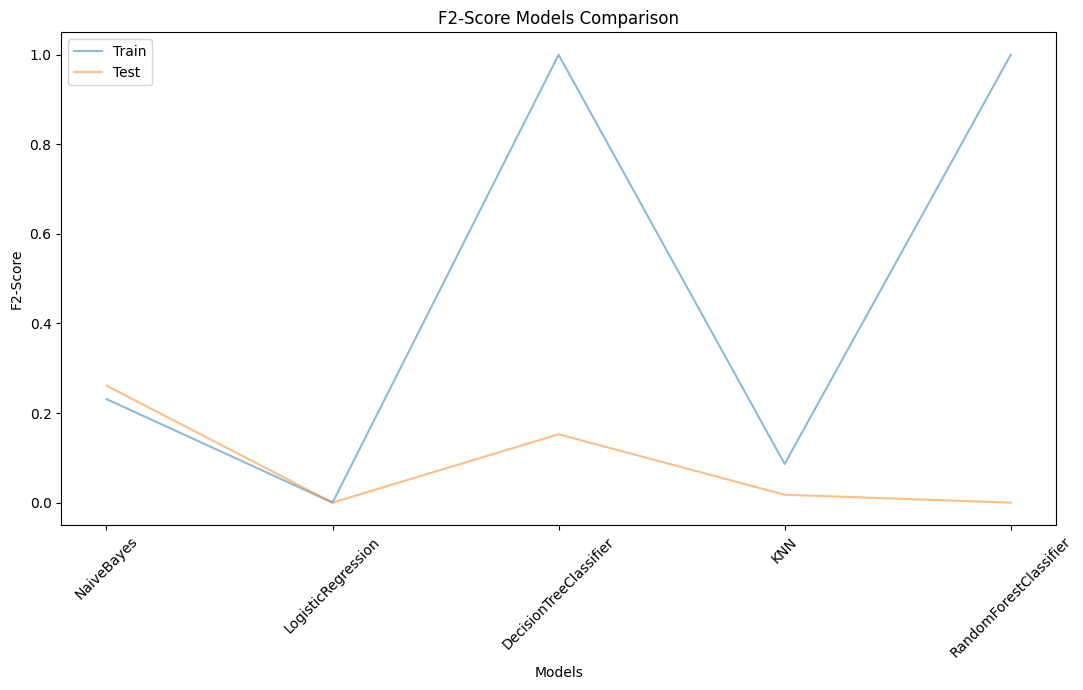

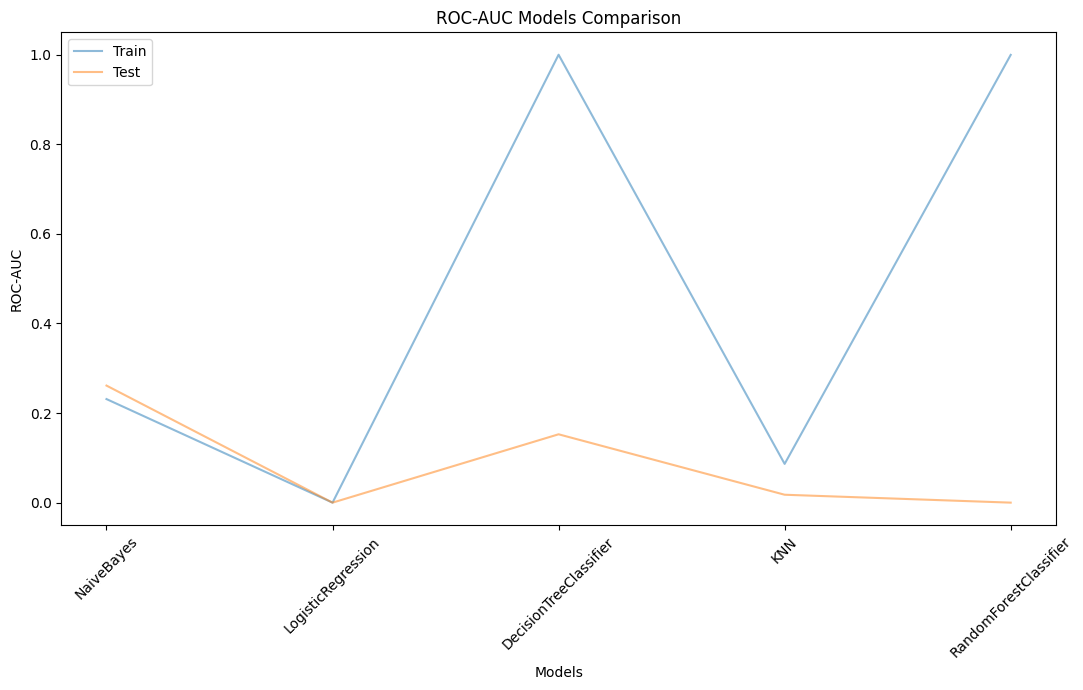

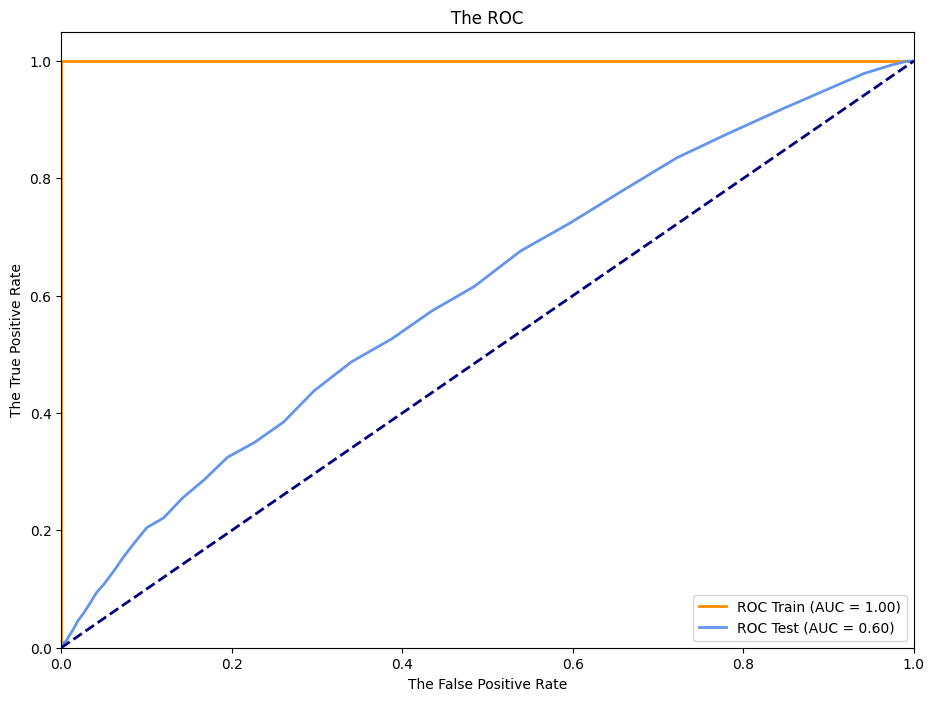

In [ ]:
#METHODLOGY 2: SELECTED FEATURES

#Splitting the dataset into training and test sets
meth2_features = data.drop([ 'default', 'loss'], axis=1)
meth2_target = data['default']

X_train, X_test, y_train, y_test = train_test_split(meth2_features, meth2_target, test_size=0.2, random_state=42)

#Creating a feature selection using RandomForestClassifier script
features_select = RandomForestClassifier(n_estimators=100, random_state=42 )
features_select.fit(X_train, y_train)

#Selecting 25 most influencial/important features
method2_sf = SelectFromModel(features_select,max_features=25, prefit=True)
X_train_sf = method2_sf.transform(X_train)
X_test_sf = method2_sf.transform(X_test)


#Checking the dimension of selected features
X_train_sf.shape



#Creating the list of 5 classification models
class_models = {
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

# Initializing the result table
perf_table = PrettyTable()
perf_table.field_names = ['Models', 'Accuracy (Train)', 'Accuracy (Test)',
                            'F1-Score (Train)', 'F1-Score (Test)', 'F2-Score (Train)', 'F2-Score (Test)', 'ROC-AUC (Train)', 'ROC-AUC (Test)']

# Initializing lists for results visualization
metrics = ['Accuracy', 'F1-Score', 'F2-Score', 'ROC-AUC']
train_output = {metric: [] for metric in metrics}
test_output = {metric: [] for metric in metrics}

for classifier_name, classifier in class_models.items():
    print(f"Training the {classifier_name}")

    #Running the GridSearchCV script for parameter selection
    classifier_cv = GridSearchCV(classifier, param_grid={}, cv=5, error_score='raise')
    classifier_cv.fit(X_train_sf, y_train)

    #Calculating the four (4) metrics for model validation
    classifier_train_pred = classifier_cv.predict(X_train_sf)
    classifier_test_pred = classifier_cv.predict(X_test_sf)

    accuracy_train = accuracy_score(y_train, classifier_train_pred)
    accuracy_test = accuracy_score(y_test, classifier_test_pred)

    f1_train = f1_score(y_train, classifier_train_pred)
    f1_test = f1_score(y_test, classifier_test_pred)

    f2_train = fbeta_score(y_train, classifier_train_pred, beta=2)
    f2_test = fbeta_score(y_test, classifier_test_pred, beta=2)

    classifier_train_prob = classifier_cv.predict_proba(X_train_sf)[:, 1]
    classifier_test_prob = classifier_cv.predict_proba(X_test_sf)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, classifier_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, classifier_test_prob)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Print and add to table
    perf_table.add_row([classifier_name, accuracy_train, accuracy_test, f1_train, f1_test, f2_train, f2_test, roc_auc_train, roc_auc_test])


    #Storing the scores for results visualization
    train_output['Accuracy'].append(accuracy_train)
    test_output['Accuracy'].append(accuracy_test)

    train_output['F1-Score'].append(f1_train)
    test_output['F1-Score'].append(f1_test)

    train_output['F2-Score'].append(f2_train)
    test_output['F2-Score'].append(f2_test)

    train_output['ROC-AUC'].append(f2_train)
    test_output['ROC-AUC'].append(f2_test)


# Display the result table
print(perf_table)


for metric in metrics:
    plt.figure(figsize=(11, 7))
    if metric == 'Accuracy':
        plt.scatter(class_models.keys(), train_output[metric], label='Train', alpha=0.5)
        plt.scatter(class_models.keys(), test_output[metric], label='Test', alpha=0.5)
        plt.plot(class_models.keys(), train_output[metric], linestyle='--')
        plt.plot(class_models.keys(), test_output[metric], linestyle='--')
    else:
        plt.plot(class_models.keys(), train_output[metric], label='Train', alpha=0.5)
        plt.plot(class_models.keys(), test_output[metric], label='Test', alpha=0.5)
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'Methodology 2:{metric} Models Comparison')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(11, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Train (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'ROC Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('The False Positive Rate')
plt.ylabel('The True Positive Rate')
plt.title('The ROC')
plt.legend(loc="lower right")
plt.show()

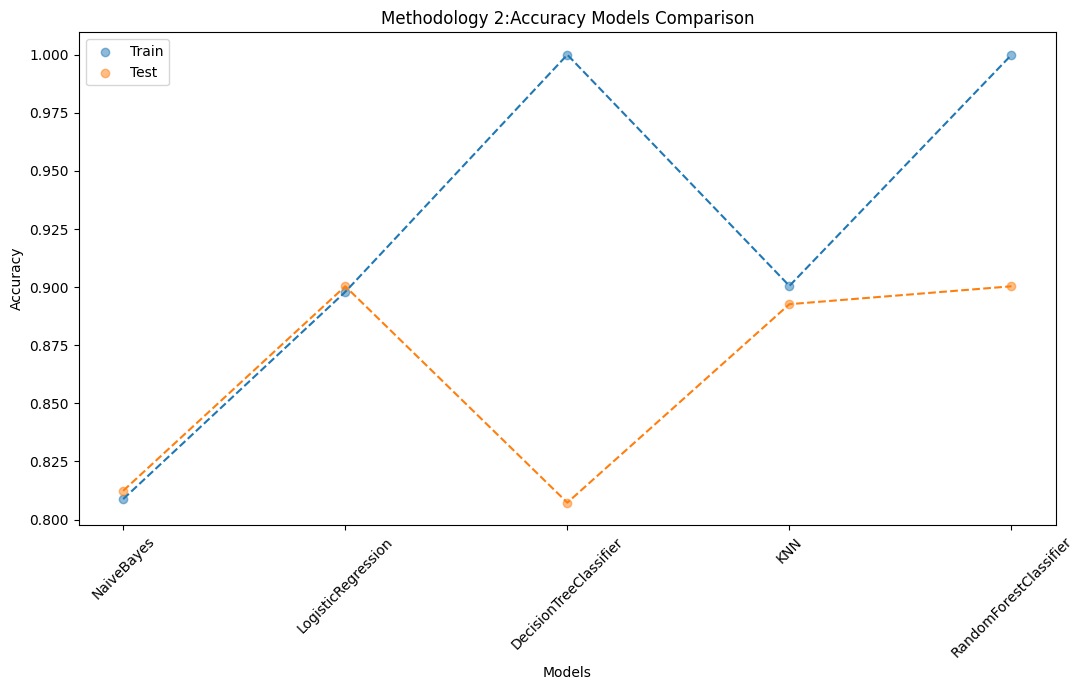

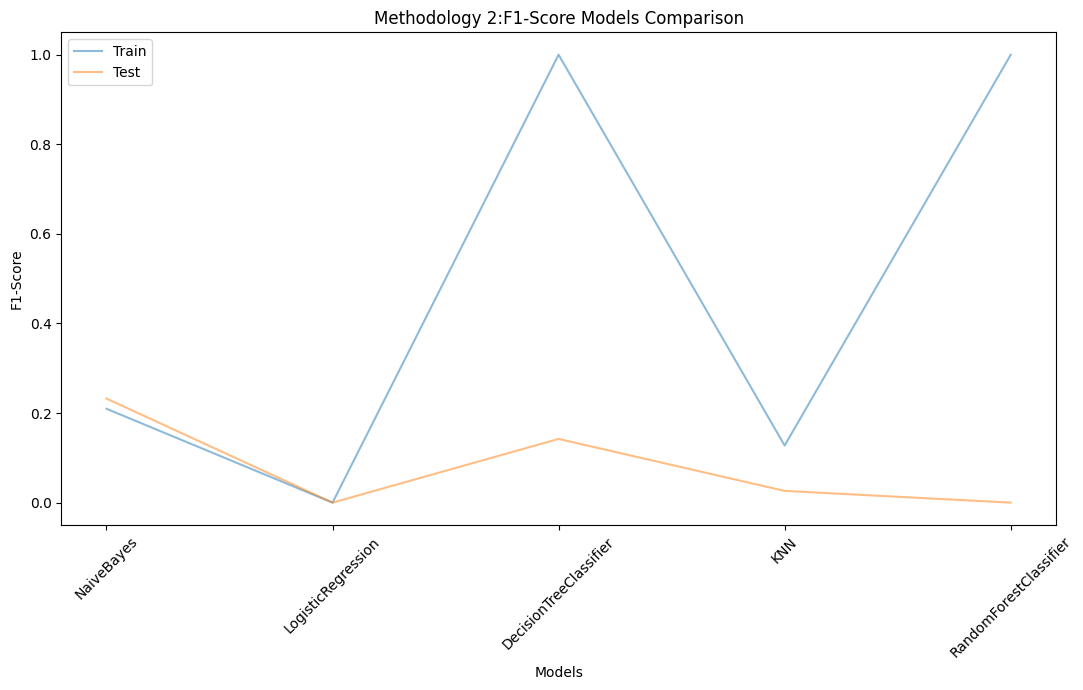

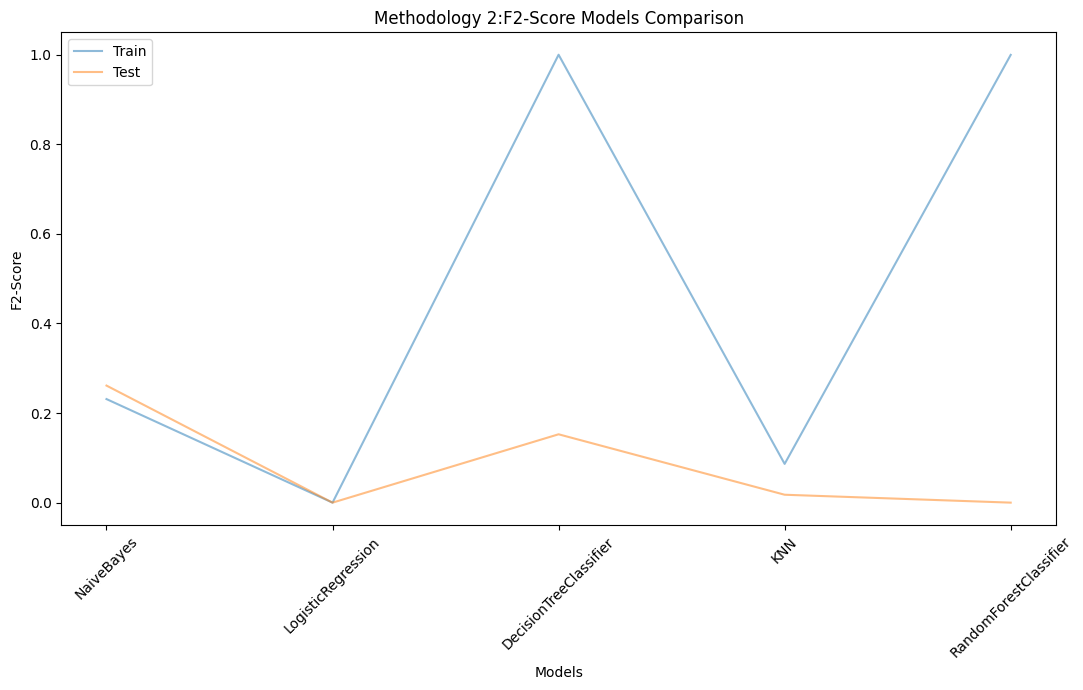

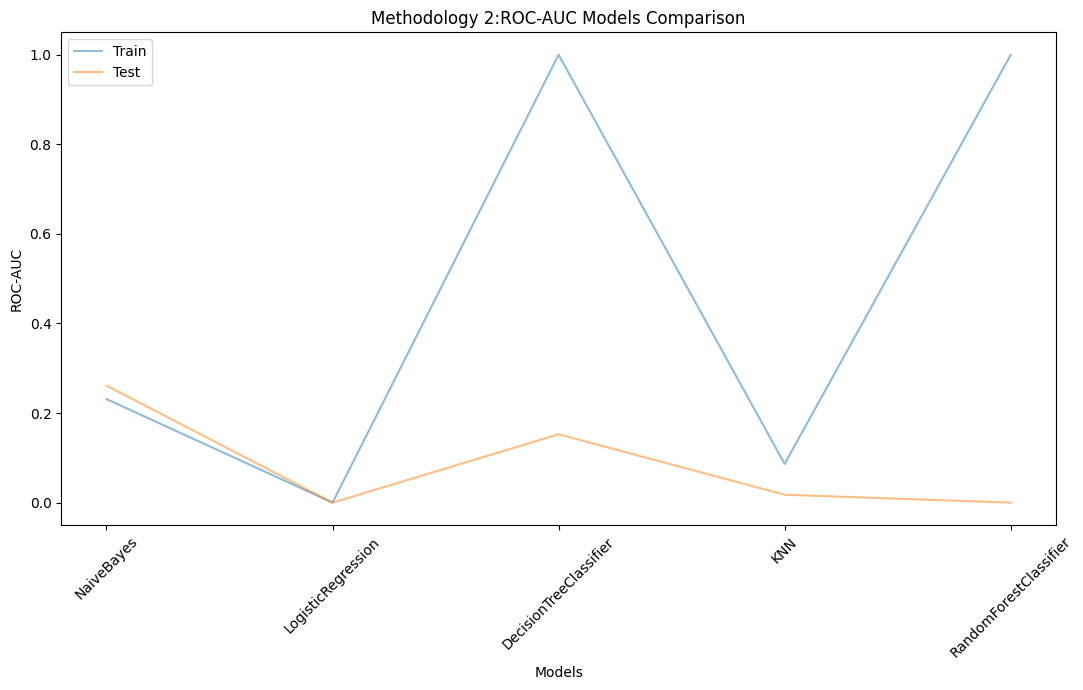

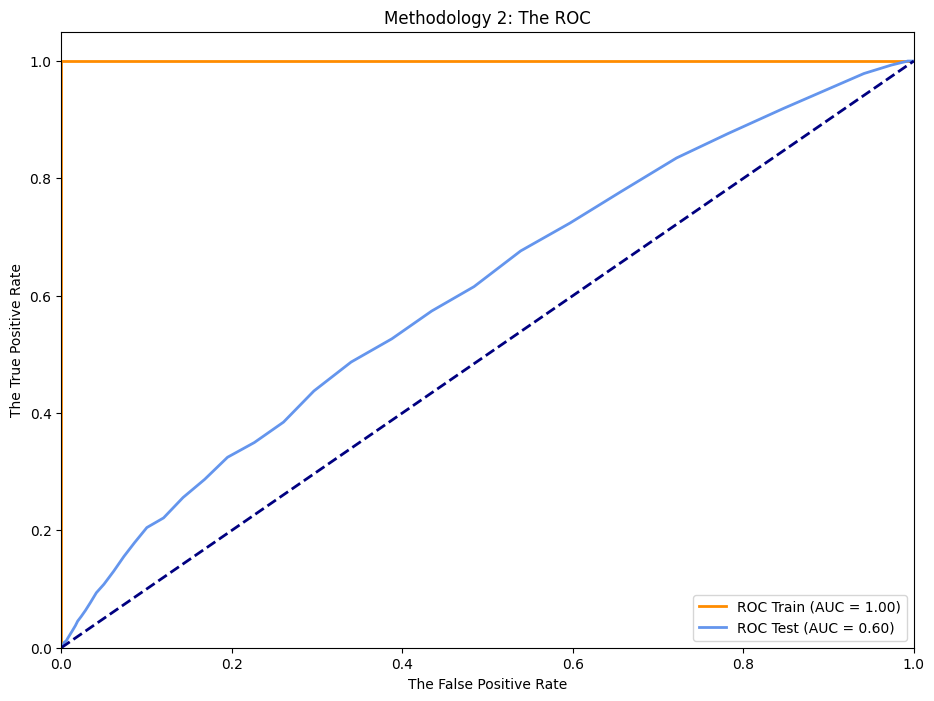

In [ ]:
for metric in metrics:
    plt.figure(figsize=(11, 7))
    if metric == 'Accuracy':
        plt.scatter(class_models.keys(), train_output[metric], label='Train', alpha=0.5)
        plt.scatter(class_models.keys(), test_output[metric], label='Test', alpha=0.5)
        plt.plot(class_models.keys(), train_output[metric], linestyle='--')
        plt.plot(class_models.keys(), test_output[metric], linestyle='--')
    else:
        plt.plot(class_models.keys(), train_output[metric], label='Train', alpha=0.5)
        plt.plot(class_models.keys(), test_output[metric], label='Test', alpha=0.5)
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'Methodology 2:{metric} Models Comparison')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(11, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Train (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'ROC Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('The False Positive Rate')
plt.ylabel('The True Positive Rate')
plt.title('Methodology 2: The ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Get the indices of the selected features
selected_feature_indices = method2_sf.get_support(indices=True)

# Get the names of the selected features from the original dataframe columns
selected_feature_names = meth2_features.columns[selected_feature_indices]

# Print or display the names of the selected features
print(selected_feature_names)


Index(['id', 'f3', 'f67', 'f76', 'f211', 'f212', 'f271', 'f281', 'f366',
       'f384', 'f393', 'f404', 'f412', 'f432', 'f596', 'f598', 'f614', 'f629',
       'f638', 'f655', 'f670', 'f672', 'f673', 'f746', 'f767'],
      dtype='object')


In [ ]:
#Listing the names of 25 most influential features
selected_features_influence = method2_sf.get_support(indices=True)

#Extracting the names of the selected features
selected_features_names = meth2_features.columns[selected_features_influence]

#Printing the names of the selected features
print(selected_features_names)


Index(['id', 'f3', 'f67', 'f76', 'f211', 'f212', 'f271', 'f281', 'f366',
       'f384', 'f393', 'f404', 'f412', 'f432', 'f596', 'f598', 'f614', 'f629',
       'f638', 'f655', 'f670', 'f672', 'f673', 'f746', 'f767'],
      dtype='object')


In [ ]:
g = 44
g

44

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
# Create a RandomForestClassifier for feature selection
feature_selector = RandomForestClassifier(n_estimators=100, random_state=42 )
feature_selector.fit(X_train, y_train)

# Select important features
selected_features = SelectFromModel(feature_selector,max_features=25, prefit=True)
X_train_selected = selected_features.transform(X_train)
X_test_selected = selected_features.transform(X_test)

In [ ]:
X_train_selected.shape

(41552, 25)

In [ ]:
# Define classifiers
classifiers = {
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

# Initialize the table
result_table = PrettyTable()
result_table.field_names = ['Classifier', 'Accuracy (Train)', 'Accuracy (Test)', 'F1-Score (Train)', 'F1-Score (Test)', 'F2-Score (Train)', 'F2-Score (Test)', 'ROC-AUC (Train)', 'ROC-AUC (Test)' ]

# Initialize lists for visualization
metrics = ['Accuracy', 'F1-Score', 'F2-Score', 'ROC-AUC']
train_scores = {metric: [] for metric in metrics}
test_scores = {metric: [] for metric in metrics}

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}")

    # Perform GridSearchCV for parameter selection
    clf_cv = GridSearchCV(clf, param_grid={}, cv=5, error_score='raise')
    clf_cv.fit(X_train_selected, y_train)

    # Calculate metrics for validation
    clf_train_pred = clf_cv.predict(X_train_selected)
    clf_test_pred = clf_cv.predict(X_test_selected)

    accuracy_train = accuracy_score(y_train, clf_train_pred)
    accuracy_test = accuracy_score(y_test, clf_test_pred)

    #mse_train = mean_squared_error(y_train, clf_train_pred)
    #mse_test = mean_squared_error(y_test, clf_test_pred)

    f1_train = f1_score(y_train, clf_train_pred)
    f1_test = f1_score(y_test, clf_test_pred)

    f2_train = fbeta_score(y_train, clf_train_pred, beta=2)
    f2_test = fbeta_score(y_test, clf_test_pred, beta=2)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Print and add to table
    result_table.add_row([clf_name, accuracy_train, accuracy_test,  f1_train, f1_test, f2_train, f2_test, roc_auc_train, roc_auc_test])

    # Store scores for visualization
    train_scores['Accuracy'].append(accuracy_train)
    test_scores['Accuracy'].append(accuracy_test)

    #train_scores['MSE'].append(mse_train)
    #test_scores['MSE'].append(mse_test)

    train_scores['F1-Score'].append(f1_train)
    test_scores['F1-Score'].append(f1_test)

    train_scores['F2-Score'].append(f2_train)
    test_scores['F2-Score'].append(f2_test)

    train_scores['ROC-AUC'].append(f2_train)
    test_scores['ROC-AUC'].append(f2_test)

# Display the result table
print(result_table)

Training NaiveBayes
Training LogisticRegression
Training DecisionTreeClassifier
Training KNN
Training RandomForestClassifier
+------------------------+--------------------+--------------------+---------------------+----------------------+---------------------+----------------------+--------------------+--------------------+
|       Classifier       |  Accuracy (Train)  |  Accuracy (Test)   |   F1-Score (Train)  |   F1-Score (Test)    |   F2-Score (Train)  |   F2-Score (Test)    |  ROC-AUC (Train)   |   ROC-AUC (Test)   |
+------------------------+--------------------+--------------------+---------------------+----------------------+---------------------+----------------------+--------------------+--------------------+
|       NaiveBayes       | 0.8088178667693493 | 0.8123796688486715 | 0.20955223880597013 | 0.23237495076801887  | 0.23122529644268772 | 0.26133947554925585  | 0.9999999999999999 | 0.6037972780956897 |
|   LogisticRegression   | 0.8979591836734694 | 0.9003658067000385 |   

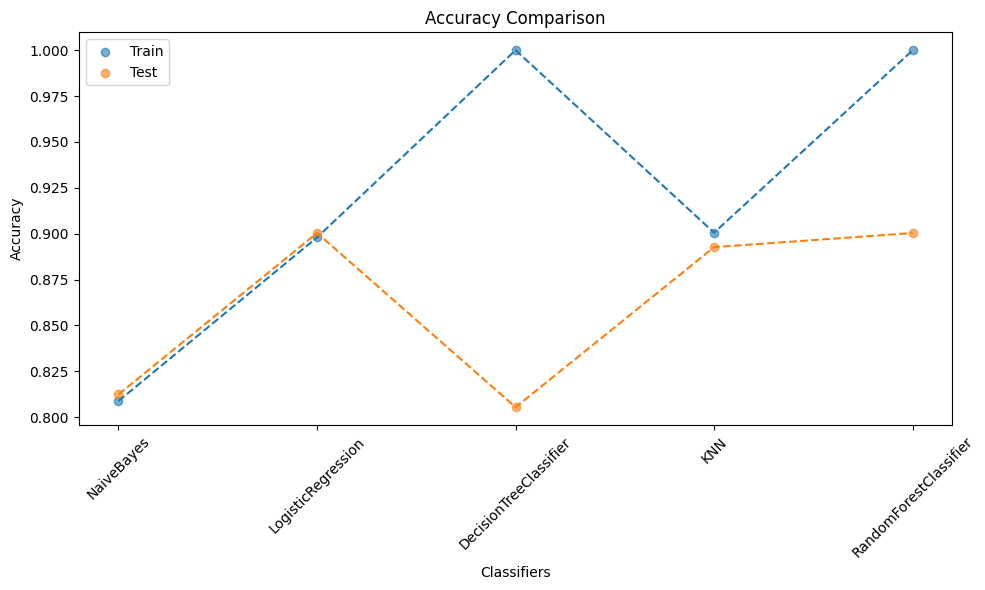

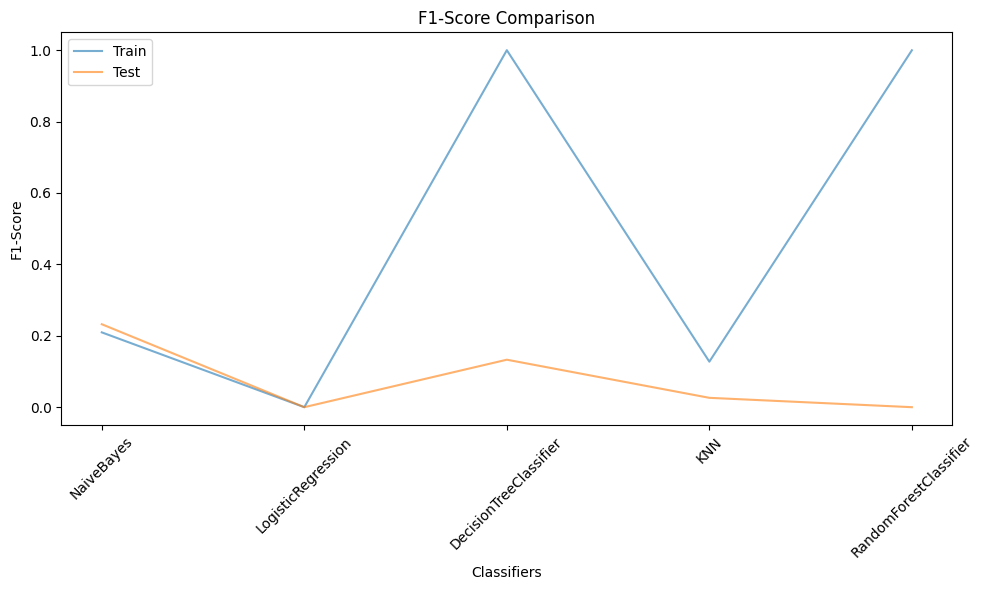

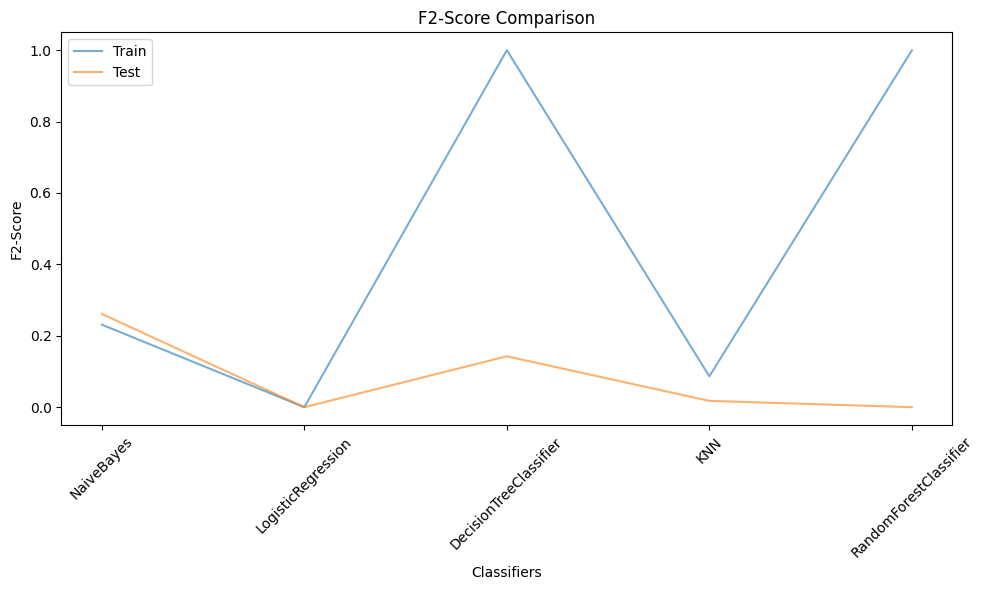

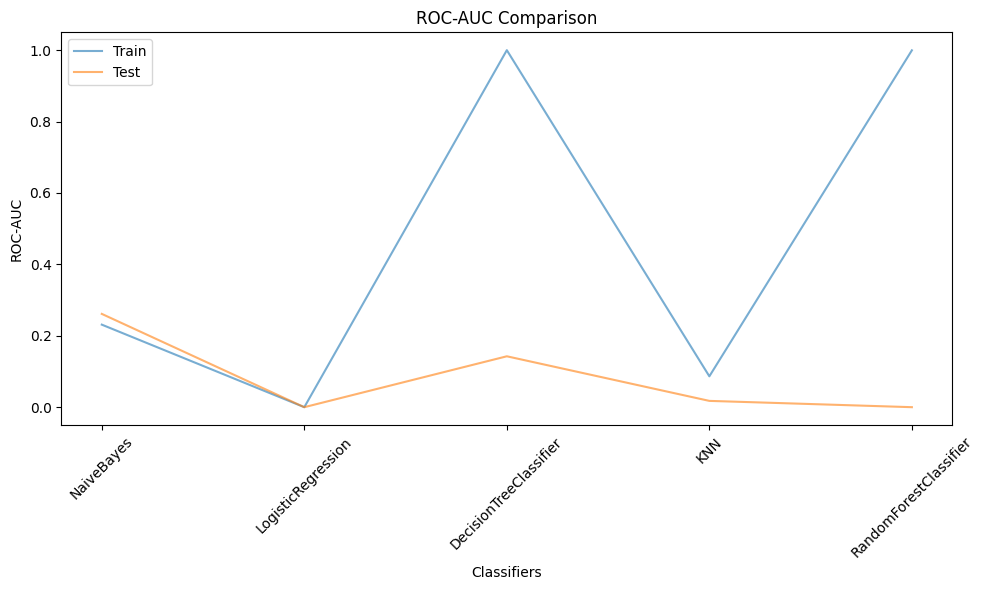

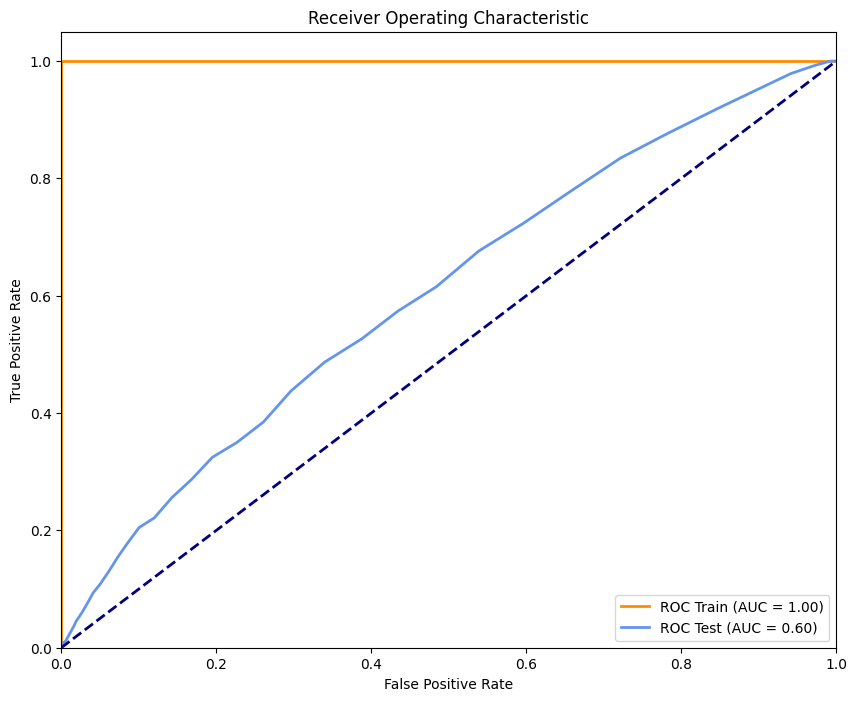

In [ ]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    if metric == 'Accuracy':
        plt.scatter(classifiers.keys(), train_scores[metric], label='Train', alpha=0.6)
        plt.scatter(classifiers.keys(), test_scores[metric], label='Test', alpha=0.6)
        plt.plot(classifiers.keys(), train_scores[metric], linestyle='--')
        plt.plot(classifiers.keys(), test_scores[metric], linestyle='--')
    else:
        plt.plot(classifiers.keys(), train_scores[metric], label='Train', alpha=0.6)
        plt.plot(classifiers.keys(), test_scores[metric], label='Test', alpha=0.6)
    plt.xlabel('Classifiers')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Train (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'ROC Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
